In [231]:
import numpy as np
import json
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import pandas as pd
import collections

In [232]:
def sem(x,axis=0):
    return np.std(x)/np.sqrt(x.shape[0])

def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

In [233]:
direc = 'C:/Users/svo/Documents/Sourcetree repos/planning-as-information-seeking/'

In [234]:
with open(direc + 'demo_viz.json','r')as f:
    data = json.load(f)
    
#with open(direc + 'demo_viz_params.json','r')as f:
#    data_params = json.load(f)


In [235]:
def get_KL(p,q):
    kl = p*np.log(p)-p*np.log(q)
    return np.nansum(kl)

def get_JS(p,q):
    return get_KL(p,(p+q)/2)+get_KL(q,(p+q)/2)

def get_nll(trial,model):
    return [-np.log(p[k+1]) for p,k in zip(trial['demo']['predictions'][model],trial['demo']['clicks'] + [-1])]

def get_p_stop(trial,model):
    return [p[0] for p in trial['demo']['predictions'][model]]

def get_KL_bfs_optimal(trial):
    P = np.array(trial['demo']['predictions']['Optimal'])
    Q = np.array(trial['demo']['predictions']['NewBestFirst'])
    return [get_JS(p,q) for p,q in zip(P,Q)]

In [236]:
nll_opt = [[get_nll(trial,'Optimal') for trial in d['trials']] for d in data]
nll_bfs = [[get_nll(trial,'NewBestFirst') for trial in d['trials']] for d in data]
p_stop = [[get_p_stop(trial,'Optimal') for trial in d['trials']] for d in data]
all_kl = [[[[i,j,k,len(trial['demo']['clicks'])-k,kl] for k,kl in enumerate(get_KL_bfs_optimal(trial))] 
           for j,trial in enumerate(d['trials'])] for i,d in enumerate(data)]

for _ in range(2):#the ugliest way ever to flatten a nested list
    all_kl = sum(all_kl,[])
    nll_opt = sum(nll_opt,[])
    nll_bfs = sum(nll_bfs,[])
    p_stop = sum(p_stop,[])
    


C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [237]:
X = np.hstack([np.array(all_kl),np.array(nll_opt)[:,None],np.array(nll_bfs)[:,None],np.array(p_stop)[:,None]])
X = X[np.argsort(X[:,4])[::-1],:]
df = pd.DataFrame(X,columns=['part','trial','clicks','clicks_to_end','kl','nll_opt','nll_bfs','p_stop_opt'])

In [238]:
np.mean(np.exp(-df['nll_opt']))

0.3663157630023761

In [239]:
df['nll_bfs'].sum()

3852.3465568236707

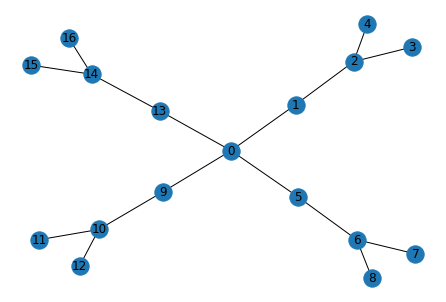

In [242]:
graph = [[2, 6, 10, 14], [3], [4, 5], [], [], [7], [8, 9], [], [], [11], [12, 13], [], [], [15], [16, 17], [], []]
G=nx.Graph()
G.add_nodes_from(range(1,len(graph)))
G.add_edges_from(sum([[(v1-1,v2) for v1 in edges] for v2,edges in enumerate(graph)],[]))
pos=nx.drawing.layout.spring_layout(G)
nx.draw(G,pos=pos,labels=dict(zip(G.nodes,G.nodes)))

In [245]:
def plot_trial(trial,k):
    f, axs = plt.subplots(1,2,figsize=(12,6))
            
    chosen_node = trial['demo']['clicks'][k] if k<len(trial['demo']['clicks']) else 0
    print('participant',i,'trial',j,'click',k)
    print('bfs params',trial['demo']['parameters']['NewBestFirst'])
    print('opt params',trial['demo']['parameters']['Optimal'])
    
    plt.subplot(121)
    node_interior_color = [cm.Blues(trial['demo']['predictions']['Optimal'][k][0 if i==0 else i+1]) for i in G.nodes]
    node_border_color = ['r' if i==chosen_node else 'black' for i in G.nodes]
    node_labels = [int(trial['stateRewards'][i]) if i in trial['demo']['clicks'][:k] else '' for i in G.nodes]
    node_labels = dict(zip(range(1,len(node_labels)),node_labels))
    nx.draw_networkx_nodes(G,pos=pos,node_color = node_interior_color,edgecolors = node_border_color,linewidth=5)
    nx.draw_networkx_edges(G,pos=pos)
    nx.draw_networkx_labels(G, pos, node_labels, font_size=12)
    plt.title('Optimal')
    plt.axis("off")

    plt.subplot(122)
    node_interior_color = [cm.Blues(trial['demo']['predictions']['NewBestFirst'][k][0 if i==0 else i+1]) for i in G.nodes]
    node_border_color = ['r' if i==chosen_node else 'black' for i in G.nodes]
    node_labels = [int(trial['stateRewards'][i]) if i in trial['demo']['clicks'][:k] else '' for i in G.nodes]
    node_labels = dict(zip(range(1,len(node_labels)),node_labels))
    nx.draw_networkx_nodes(G,pos=pos,node_color = node_interior_color,edgecolors = node_border_color,linewidth=5)
    nx.draw_networkx_edges(G,pos=pos)
    nx.draw_networkx_labels(G, pos, node_labels, font_size=12)
    plt.title('NewBestFirst')
    plt.axis("off")
    plt.show()


participant 10 trial 16 click 5
bfs params {'beta_term': 0.4301130554759285, 'beta_click': 0.5838801130581914, 'epsilon': 4.319575482555896e-19, 'Î¸_term': 9.974563759437677}
opt params {'cost': 1.0, 'beta': 49.99999999999999, 'epsilon': 0.13747927543716587}


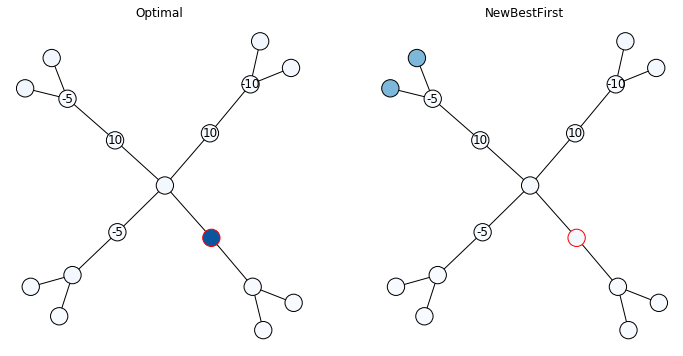

participant 10 trial 16 click 4
bfs params {'beta_term': 0.4301130554759285, 'beta_click': 0.5838801130581914, 'epsilon': 4.319575482555896e-19, 'Î¸_term': 9.974563759437677}
opt params {'cost': 1.0, 'beta': 49.99999999999999, 'epsilon': 0.13747927543716587}


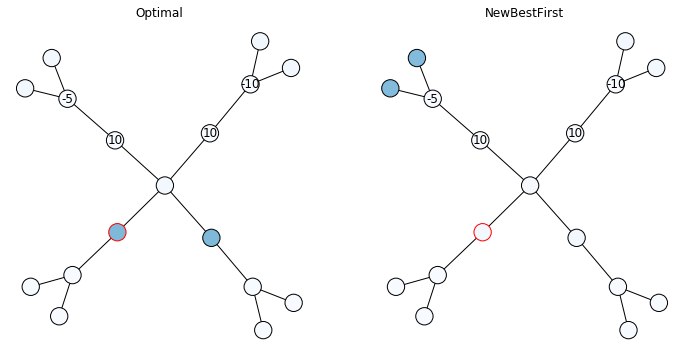

participant 13 trial 13 click 6
bfs params {'beta_term': 2.9999999999999996, 'beta_click': 0.3623903659800821, 'epsilon': 1.0289005991551732e-21, 'Î¸_term': 0.7529271792585747}
opt params {'cost': 2.11, 'beta': 3.9522831028708874, 'epsilon': 0.11500004138122706}


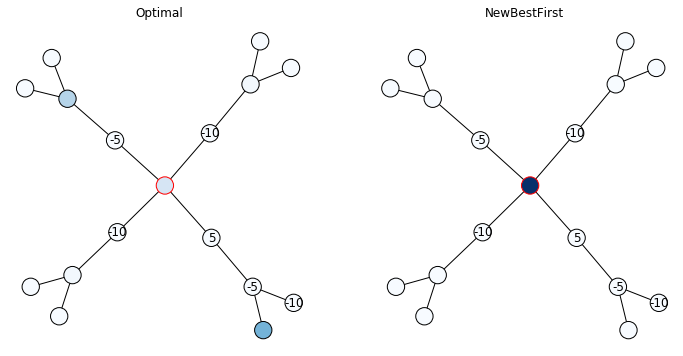

participant 4 trial 12 click 6
bfs params {'beta_term': 2.4939451027660806, 'beta_click': 0.5720600929052161, 'epsilon': 3.5781160527635483e-17, 'Î¸_term': 0.5237692087721689}
opt params {'cost': 2.14, 'beta': 3.3946784724064, 'epsilon': 0.2677762904291767}


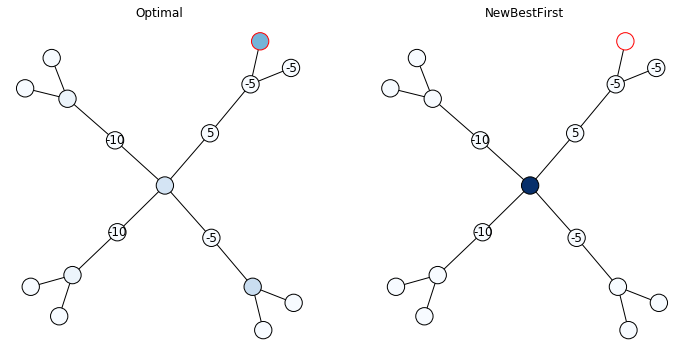

participant 2 trial 5 click 6
bfs params {'beta_term': 0.712312717298346, 'beta_click': 0.21467290633606356, 'epsilon': 1.004422053983572e-21, 'Î¸_term': 9.28777528301292}
opt params {'cost': 1.0, 'beta': 3.904859038090696, 'epsilon': 4.399204970860837e-19}


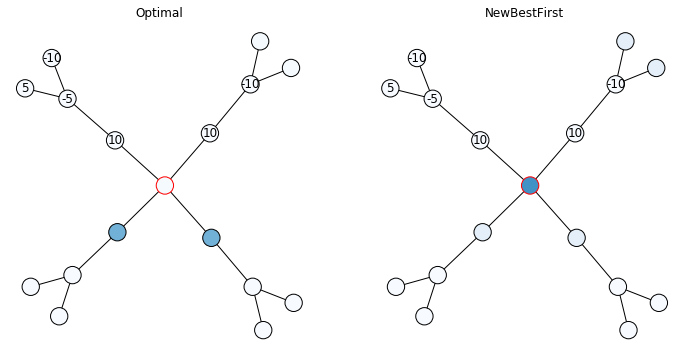

participant 16 trial 0 click 3
bfs params {'beta_term': 2.99999999999544, 'beta_click': 0.15477431522032079, 'epsilon': 1.6146330694020095e-22, 'Î¸_term': 0.43309429613780376}
opt params {'cost': 2.68, 'beta': 0.6160267567100658, 'epsilon': 2.465548812559228e-16}


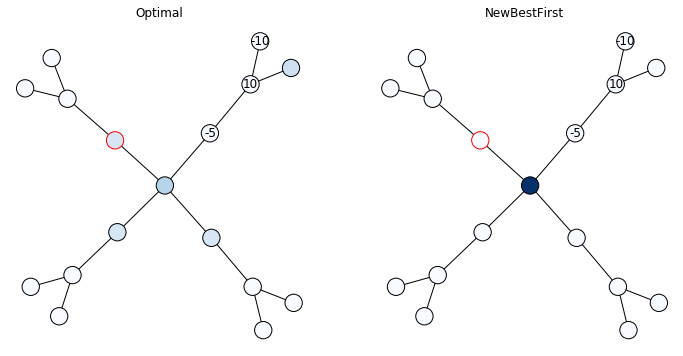

participant 10 trial 9 click 4
bfs params {'beta_term': 0.5362049853811272, 'beta_click': 0.4804381634357002, 'epsilon': 1.601333793189246e-16, 'Î¸_term': 8.170401319867139}
opt params {'cost': 1.12, 'beta': 49.99999999999983, 'epsilon': 0.1371349782008249}


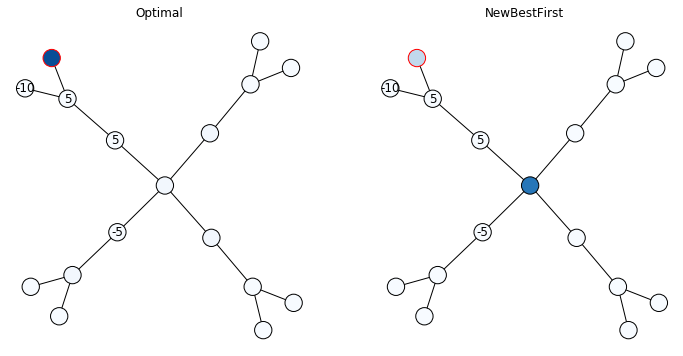

participant 13 trial 6 click 5
bfs params {'beta_term': 2.999999999985353, 'beta_click': 0.3872237940581355, 'epsilon': 4.2592057035858155e-21, 'Î¸_term': 0.8498142126728809}
opt params {'cost': 2.11, 'beta': 2.866812215379845, 'epsilon': 0.09575591253156128}


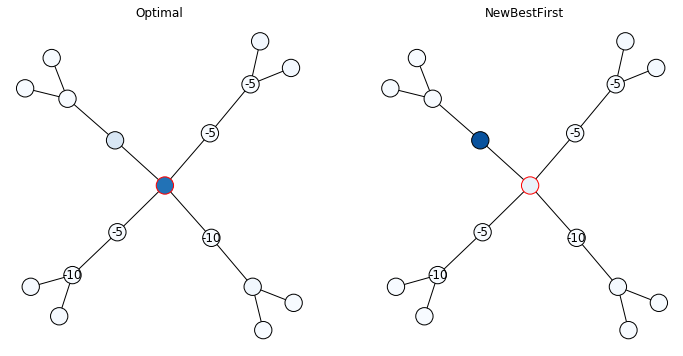

participant 10 trial 4 click 6
bfs params {'beta_term': 0.5362049853811272, 'beta_click': 0.4804381634357002, 'epsilon': 1.601333793189246e-16, 'Î¸_term': 8.170401319867139}
opt params {'cost': 1.12, 'beta': 49.99999999999983, 'epsilon': 0.1371349782008249}


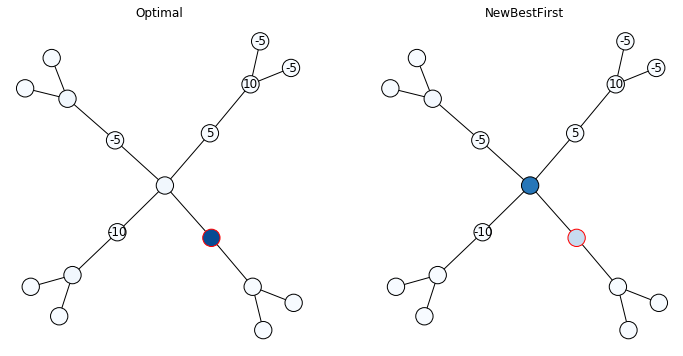

participant 10 trial 4 click 5
bfs params {'beta_term': 0.5362049853811272, 'beta_click': 0.4804381634357002, 'epsilon': 1.601333793189246e-16, 'Î¸_term': 8.170401319867139}
opt params {'cost': 1.12, 'beta': 49.99999999999983, 'epsilon': 0.1371349782008249}


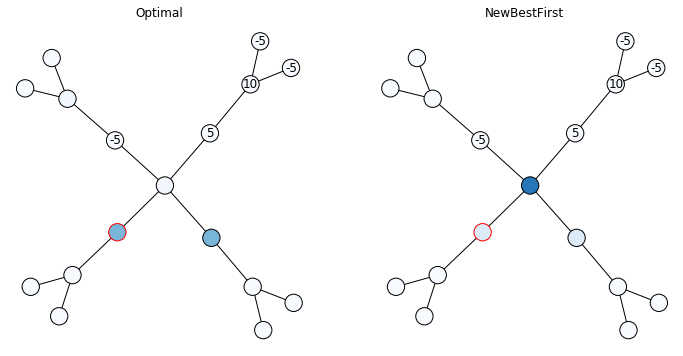

participant 10 trial 4 click 4
bfs params {'beta_term': 0.5362049853811272, 'beta_click': 0.4804381634357002, 'epsilon': 1.601333793189246e-16, 'Î¸_term': 8.170401319867139}
opt params {'cost': 1.12, 'beta': 49.99999999999983, 'epsilon': 0.1371349782008249}


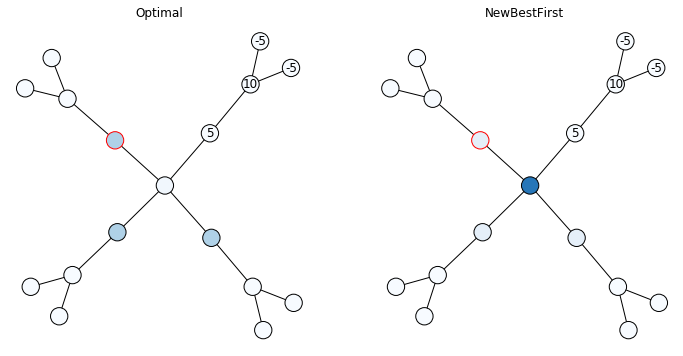

participant 19 trial 7 click 6
bfs params {'beta_term': 0.26528434762119024, 'beta_click': 0.619168048842837, 'epsilon': 0.03991746565300502, 'Î¸_term': 9.72614414854646}
opt params {'cost': 1.96, 'beta': 1.8442203142555114, 'epsilon': 0.13179333793250342}


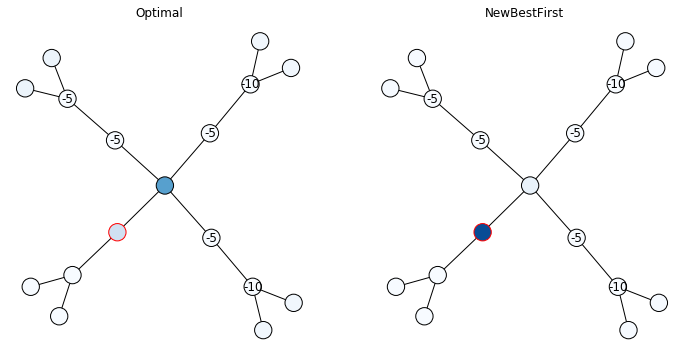

participant 0 trial 16 click 5
bfs params {'beta_term': 0.4675737042959228, 'beta_click': 0.6242342992627821, 'epsilon': 8.775521796760648e-27, 'Î¸_term': 9.576047327407956}
opt params {'cost': 1.24, 'beta': 7.20893120140132, 'epsilon': 0.018294531235179917}


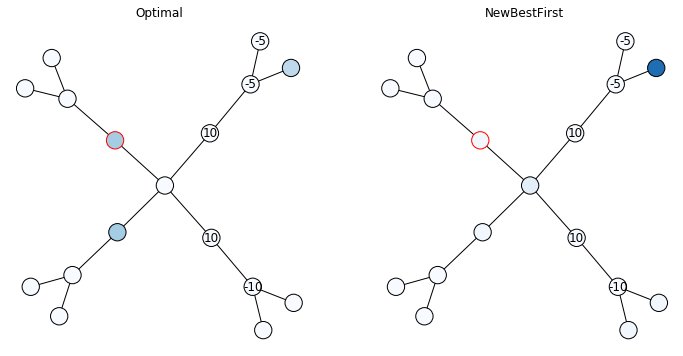

participant 1 trial 19 click 4
bfs params {'beta_term': 0.46702713859094963, 'beta_click': 0.6767085826793909, 'epsilon': 2.7088588145160504e-18, 'Î¸_term': 3.246997582057733}
opt params {'cost': 1.9, 'beta': 5.928455702743811, 'epsilon': 0.3435719945008937}


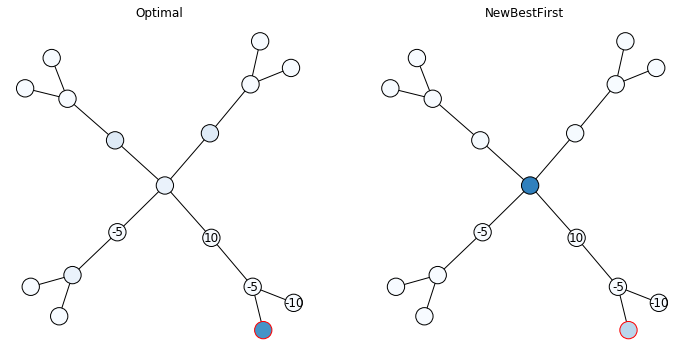

participant 12 trial 14 click 6
bfs params {'beta_term': 0.5642301112611061, 'beta_click': 0.32925833919036107, 'epsilon': 1.9620694333076524e-16, 'Î¸_term': 6.73644550308472}
opt params {'cost': 1.24, 'beta': 5.173252238306834, 'epsilon': 0.0535821704793821}


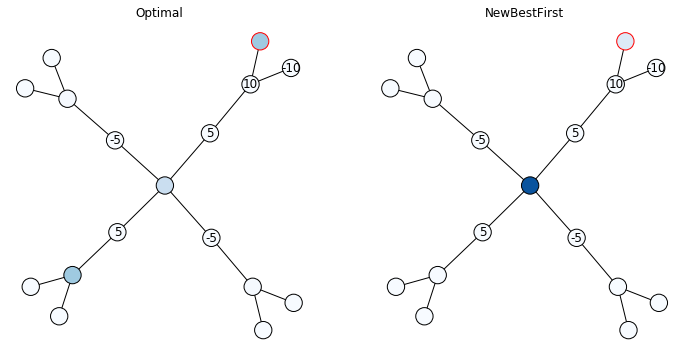

participant 9 trial 0 click 3
bfs params {'beta_term': 0.31185615044385956, 'beta_click': 0.3520147524264997, 'epsilon': 5.215270073550521e-16, 'Î¸_term': 2.6003342087361543}
opt params {'cost': 2.89, 'beta': 1.5807211464942947, 'epsilon': 7.13467150463062e-19}


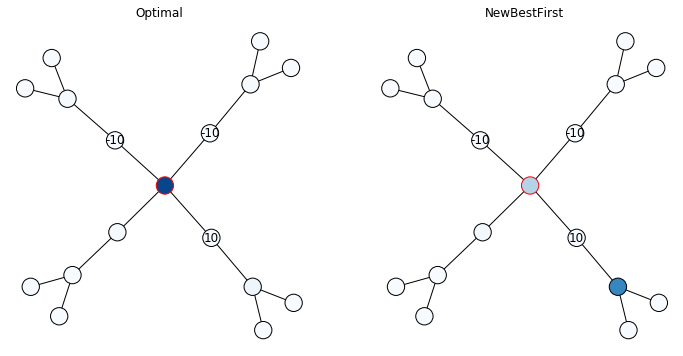

participant 12 trial 7 click 6
bfs params {'beta_term': 0.45450623908016674, 'beta_click': 0.2801669547142833, 'epsilon': 1.6321208868055318e-19, 'Î¸_term': 8.031848356807675}
opt params {'cost': 1.21, 'beta': 4.51695618093848, 'epsilon': 0.07019073849185263}


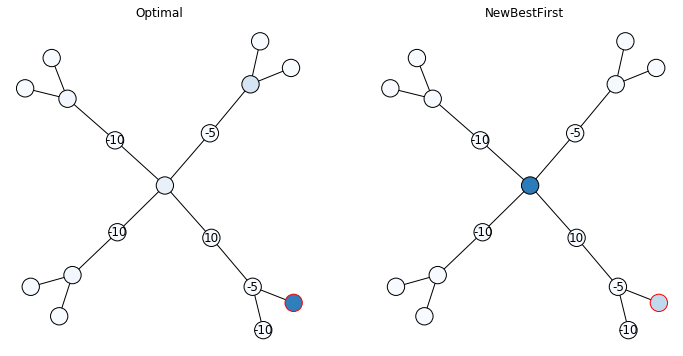

participant 10 trial 10 click 4
bfs params {'beta_term': 0.4220164369097836, 'beta_click': 0.48270055879390916, 'epsilon': 1.2536067800106513e-16, 'Î¸_term': 9.77253255118786}
opt params {'cost': 1.12, 'beta': 49.999999999999396, 'epsilon': 0.13656790890566695}


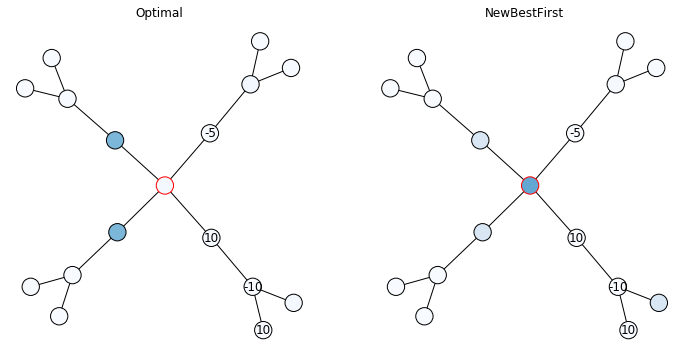

participant 11 trial 1 click 3
bfs params {'beta_term': 0.34468250608357737, 'beta_click': 0.379611067946183, 'epsilon': 1.492732142711642e-15, 'Î¸_term': 8.654908100081625}
opt params {'cost': 1.48, 'beta': 9.633341382493471, 'epsilon': 0.35997279549567696}


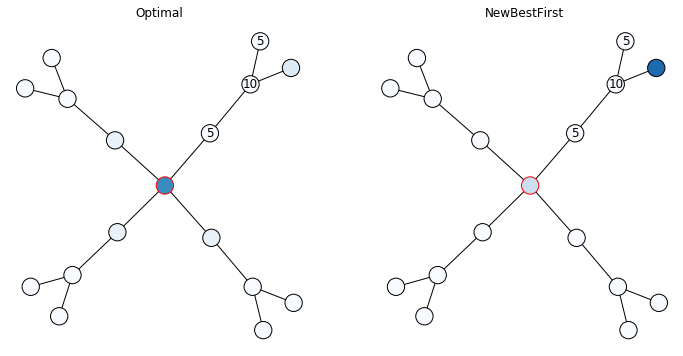

participant 1 trial 8 click 9
bfs params {'beta_term': 0.5248871418701865, 'beta_click': 2.9999999997593823, 'epsilon': 0.04237955391252389, 'Î¸_term': 2.745546467133626}
opt params {'cost': 2.05, 'beta': 6.339792509632358, 'epsilon': 0.3596716595547327}


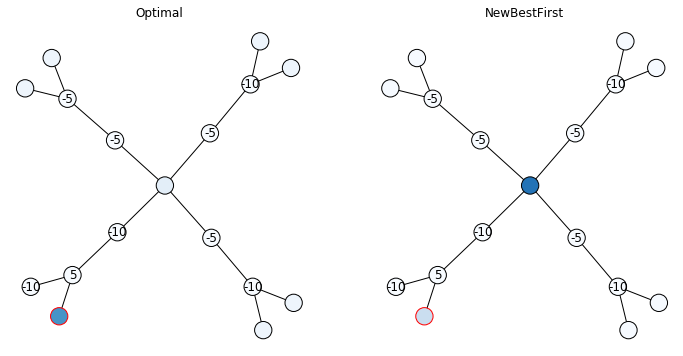

In [246]:
for i,j,k in X[:20,:3].astype(int):
    plot_trial(data[i]['trials'][j],k)

In [248]:
data[0]['trials'][0]['demo']['parameters']

{'BestFirst': {'beta_node_value': 493.3326662507798,
  'threshold_prune': -2.3843013347274,
  'beta_satisfice': 509.90831763348814,
  'beta_prune': 496.49106610597494,
  'threshold_satisfice': 2.4479083064657385,
  'epsilon': 0.07635505739083305},
 'Optimal': {'cost': 1.36,
  'beta': 7.1857553071018945,
  'epsilon': 0.023804951725634623},
 'NewBestFirst': {'beta_term': 0.5620683760129762,
  'beta_click': 0.5404588101313043,
  'epsilon': 3.099318168462105e-17,
  'Î¸_term': 7.397886416864484}}

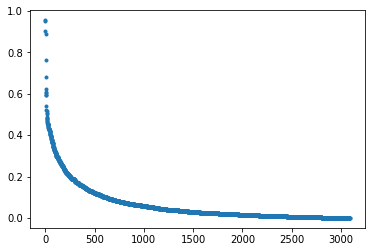

In [209]:
plt.plot(df['kl'],'.')

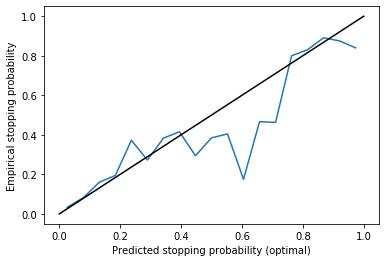

In [210]:
bins = np.linspace(0,1,20)
plt.plot((bins[1:]+bins[:-1])/2,np.histogram(df[df['clicks_to_end']==0]['p_stop_opt'].values,bins=bins)[0]/np.histogram(df['p_stop_opt'].values,bins=bins)[0])
plt.plot([0,1],[0,1],'-k')
plt.xlabel('Predicted stopping probability (optimal)')
plt.ylabel('Empirical stopping probability')
plt.show()


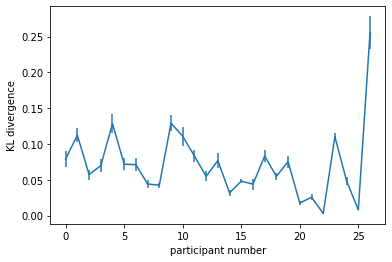

In [247]:
m = [np.mean(df[df['part']==i]['kl']) for i,_ in enumerate(data)]
s = [sem(df[df['part']==i]['kl']) for i,_ in enumerate(data)]

plt.errorbar(range(len(data)),m,s)
plt.xlabel('participant number')
plt.ylabel('KL divergence')
plt.show()

In [212]:
data[26]['wid']

'w047c9f2'

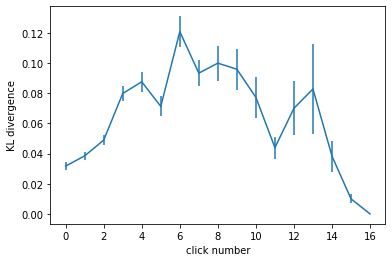

In [213]:
m = [np.mean(df[df['clicks']==i]['kl']) for i in range(17)]
s = [sem(df[df['clicks']==i]['kl']) for i in range(17)]

plt.errorbar(range(17),m,s)
plt.xlabel('click number')
plt.ylabel('KL divergence')
plt.show()

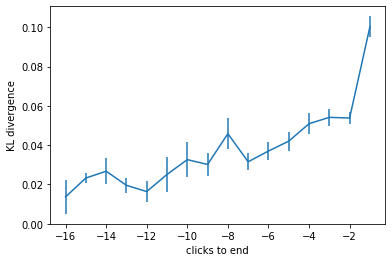

In [214]:
m = [np.mean(df[df['clicks_to_end']==-i]['kl']) for i in range(-17,0,1)]
s = [sem(df[df['clicks_to_end']==-i]['kl']) for i in range(-17,0,1)]

plt.errorbar(range(-17,0,1),m,s)
plt.xlabel('clicks to end')
plt.ylabel('KL divergence')
plt.show()

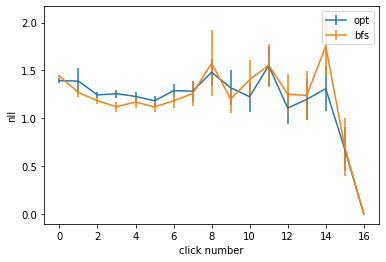

In [215]:
m = [np.mean(df[df['clicks']==i]['nll_opt']) for i in range(17)]
s = [sem(df[df['clicks']==i]['nll_opt']) for i in range(17)]

plt.errorbar(range(17),m,s,label='opt')

m = [np.mean(df[df['clicks']==i]['nll_bfs']) for i in range(17)]
s = [sem(df[df['clicks']==i]['nll_bfs']) for i in range(17)]

plt.errorbar(range(17),m,s,label='bfs')

plt.xlabel('click number')
plt.ylabel('nll')
plt.legend()
plt.show()

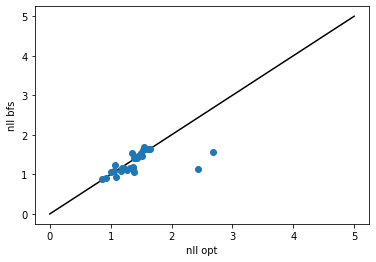

In [216]:
m1 = [np.mean(X[X[:,0]==i,5]) for i,_ in enumerate(data)]
#s = [sem(X[X[:,0]==i,4]) for i,_ in enumerate(data)]
m2 = [np.mean(X[X[:,0]==i,6]) for i,_ in enumerate(data)]
#s = [sem(X[X[:,0]==i,5]) for i,_ in enumerate(data)]

plt.plot([0,5],[0,5],'-k')
plt.plot(m1,m2,'o')

plt.xlabel('nll opt')
plt.ylabel('nll bfs')
plt.show()

In [217]:
np.argsort(np.abs(np.array(m2)-m1))

array([25,  8, 20,  0,  2, 10, 13, 22, 24,  4,  7, 12, 21, 18, 14, 15, 16,
        3,  6, 19, 11,  1,  9,  5, 17, 23, 26], dtype=int64)

In [218]:
data[23]['wid']

'w6a27621'

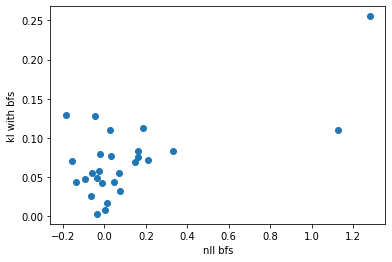

In [219]:
m1 = [np.mean(X[X[:,0]==i,5]) for i,_ in enumerate(data)]
m2 = [np.mean(X[X[:,0]==i,6]) for i,_ in enumerate(data)]
m3 = [np.mean(X[X[:,0]==i,4]) for i,_ in enumerate(data)]

#plt.plot([0,2],[0,2],'-k')
plt.plot(np.array(m1)-np.array(m2),m3,'o')

plt.ylabel('kl with bfs')
plt.xlabel('nll bfs')
plt.show()

In [220]:
def get_state(trial,k):
    return np.array([trial['stateRewards'][n] if n in trial['demo']['clicks'][:k] else np.nan for n in range(17)])

def get_all_paths(graph,node):
    if len(graph[node])==0:
        return [[node]]
    else:
        return sum([[[node] + path for path in get_all_paths(graph,child-1)] for child in graph[node]],[])

def bfs_agent(state,stopping_thresh):
    epr = np.array([np.nansum(state[np.array(path)]) for path in paths])
    is_undetermined = np.array([np.any(np.isnan(state)[np.array(path[1:])]) for path in paths])
    mer = np.array([np.max([epr[i] for i,path in enumerate(paths) if node in path]) for node in range(17)])
    best_path = np.argmax(epr)
    stop = all([epr[best_path]-epr[i]>stopping_thresh or i==best_path for i,_ in enumerate(paths) 
                    if is_undetermined[i] or is_undetermined[best_path]])
    if stop:
        return 0 #the stop action
    undetermined_paths = np.where(is_undetermined)[0]
    best_unexplored_path = paths[undetermined_paths[np.argmax(epr[undetermined_paths])]]
    first_unrevealed_node = np.nonzero(np.isnan(state[best_unexplored_path[1:]]))[0][0]+1
    return best_unexplored_path[first_unrevealed_node]

participant 1 trial 8 click 9


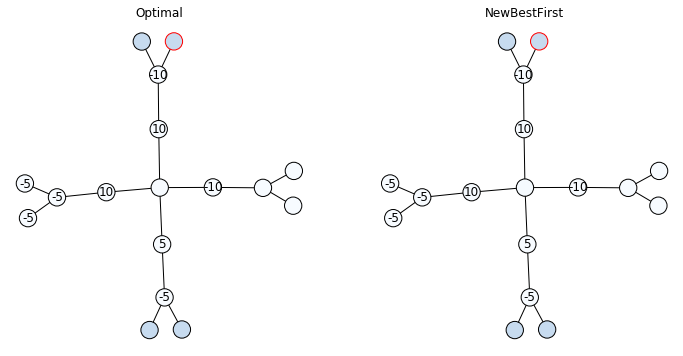

7

In [221]:
plot_trial(data[0]['trials'][16],9)
bfs_agent(states[0][16][9],4)


In [195]:
states = [[[get_state(trial,k) for k in range(len(trial['demo']['clicks'])+1)] for trial in d['trials']] for d in data]
paths = get_all_paths(graph,0)


In [196]:
def get_bfs_accuracy_trial(s,trial,thresh):
    #print(state,i,j)
    return [bfs_agent(state,thresh)==k for state,k in zip(s,trial['demo']['clicks'] + [0])]

def get_bfs_accuracy(data,thresh):
    return np.mean(list(flatten([[get_bfs_accuracy_trial(states[i][j],trial,thresh) for j,trial in enumerate(d['trials'])] for i,d in enumerate(data)])))

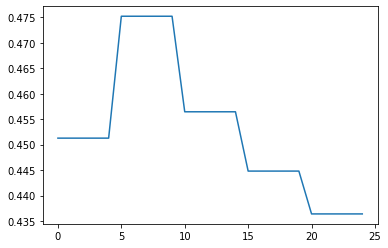

In [197]:
plt.plot([get_bfs_accuracy(data,t) for t in np.arange(25)])
plt.show()

In [ ]:
plot_trial(data[12]['trials'][4],4)

In [ ]:
paths